In [3]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error


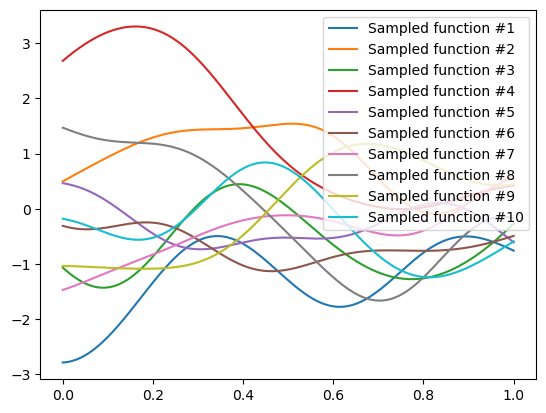

In [4]:
kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-1,10.0))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=2)

N = 31 * 29 + 1
t = np.linspace(0,1,N)
dt = t[1]-t[0]

X = t.reshape(-1, 1)
n_samples=10

y_samples = gpr.sample_y(X, n_samples)

plt.figure()
for idx, single_prior in enumerate(y_samples.T):
    plt.plot(
        t,
        single_prior,
        # linestyle="--",
        # alpha=0.7,
        label=f"Sampled function #{idx + 1}",
    )

plt.legend()

forcing_terms = y_samples.T

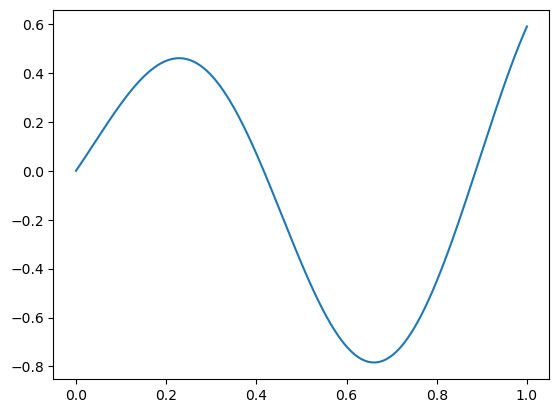

In [16]:
dt = t[1]-t[0]
    
def f(t,u, force):
    k = 9.81/0.2
    u0 = u[1]
    u1 = -k*np.sin(u[0]) + force[int(t/dt)]
    U = np.array([u0, u1])
    return U

plt.figure()
for ft in forcing_terms:
    sol = scipy.integrate.solve_ivp(lambda t, y: f(t,y,ft), y0=[0,0], t_span=[0,1],t_eval=t)
    plt.plot(sol.t, sol.y[1])

fi = forcing_terms[3]
sol = scipy.integrate.solve_ivp(lambda t, y: f(t,y,fi), y0=[0,0], t_span=[0,1],t_eval=t)
plt.plot(sol.t, sol.y[1])

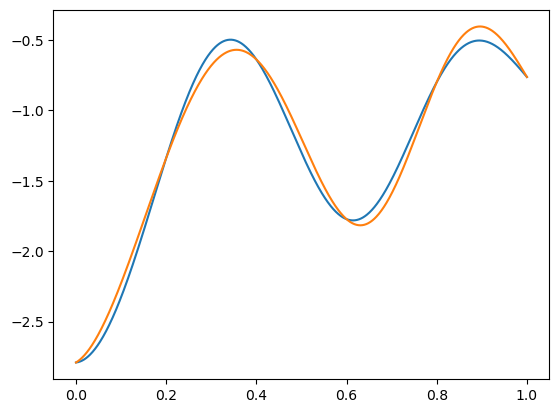

In [6]:
plt.plot(t,forcing_terms[0])
beta = 0.1
plt.plot(t, forcing_terms[0] +  beta * np.sin(5 * np.pi * t))

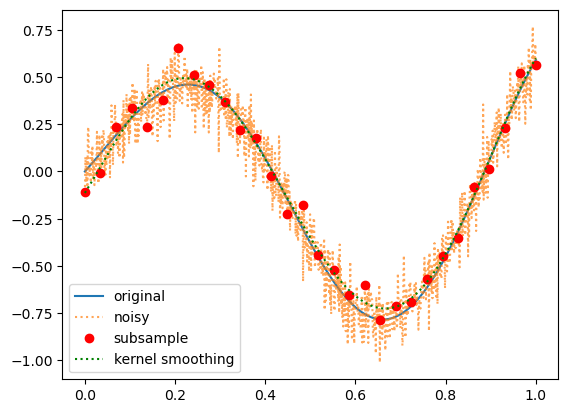

In [7]:
ut = sol.y[1]
noise = np.random.normal(0,0.1,N)
ut_perturbed = ut + noise

u_sample = ut_perturbed[::31]
t_sample = t[::31]

T_train = t_sample.reshape(-1,1)

UXX = rbf_kernel(T_train, T_train, gamma=1)

lam = 1e-4
UXX_inv_u = np.linalg.solve(UXX + lam**2*np.eye(30), u_sample)
T_test = t.reshape(-1,1)
UxX = rbf_kernel(T_test, T_train, gamma=1)
smoothed = UxX @ UXX_inv_u

plt.figure()
plt.plot(t, ut, '-', label='original')
plt.plot(t, ut_perturbed, ':', alpha=0.7, label='noisy')
plt.plot(t_sample, u_sample,'ro', label='subsample')
plt.plot(t, smoothed, 'g:', label='kernel smoothing')
plt.legend()
plt.show()

In [8]:
data = []
t_sample = t[::31]
for ft in forcing_terms:
    sol = scipy.integrate.solve_ivp(lambda t, y: f(t,y,ft), y0=[0,0], t_span=[0,1],t_eval=t)
    u = sol.y[0]
    ut = sol.y[1]
    noise = np.random.normal(0,0.1,N)
    ut_perturbed = ut + noise
    u_perturbed = u + noise

    ut_sample = ut_perturbed[::31]
    u_sample = u_perturbed[::31]

    data.append([u_sample, ut_sample, t_sample])

data = np.array(data)
data.shape

(10, 3, 30)

In [9]:
u = sol.y[0]
u_std = np.std(u)
print(u_std)

0.016893788621217255


In [10]:
ut = sol.y[1]
u = sol.y[0]
u_std = np.std(u)
noise = np.random.normal(0,0.1*u_std,N)
u_perturbed = u + noise
u_t_perturbed = ut + noise

scaler = StandardScaler()

t_sample = t[::31]
u_sample = u_perturbed[::31]
u_t_sample = u_t_perturbed[::31]

In [11]:

u_true_sample = u[::31]

def Kt(X, Y, col, l):
    K = RBF(length_scale=l)
    coeff = - (1/l**2) * (X[:,col:col+1] - Y[:, col:col+1].T)
    return coeff * K(X, Y)

def Ktt(X, Y, col, l):
    K = RBF(length_scale=l)
    coeff = (1/l**2) * ((1/l**2) * (X[:,col:col+1] - Y[:, col:col+1].T) ** 2 -1)
    return coeff * K(X,Y)

def smooth(x_train, x_test, y_train, eta, l):
    K = RBF(length_scale=l)
    UXX = K(x_train, x_train)
    UXX_nugget = (UXX + eta ** 2 * np.eye(x_train.shape[0]))
    UxX_test = K(x_test, x_train)

    return UxX_test @ np.linalg.solve(UXX_nugget, y_train)

def smoothDif(x_train, x_test, y_train, col, eta, l):
    K = RBF(length_scale=l)

    UXX = K(x_train, x_train)
    UXX_nugget = (UXX + eta ** 2 * np.eye(x_train.shape[0]))
    UxX_test = Kt(x_test, x_train, col, l)

    return UxX_test @ np.linalg.solve(UXX_nugget, y_train)

def smooth2ndDif(x_train, x_test, y_train, col, eta, l):
    K = RBF(length_scale=l)

    UXX = K(x_train, x_train)
    UXX_nugget = (UXX + eta ** 2 * np.eye(x_train.shape[0]))
    UxX_test = Ktt(x_test, x_train, col, l)

    return UxX_test @ np.linalg.solve(UXX_nugget, y_train)

0.01 0.8996576906713717
0.02 1.3076074133032756
0.03 1.1270716819599254
0.04 0.4631716054808123
0.05 1.2930837044602697
0.06 3.908752293064609
0.07 8.024279089968172
0.08 28.77063796239052
0.09 308.97492378618983
0.1 3462.627711883853
0.11 22047.417522766817
0.12 6226.935771322968
0.13 1132.2337713861023
0.14 238.92273537498076
0.15 41.39433803182674
0.16 26.65148833382238
0.17 10.432206243884517
0.18 4.707535895857973
0.19 2.205294173634978
0.2 1.3924052862351792
0.21 2.376407239648933
0.22 2.5306966622284572
0.23 1.5677217688886724
0.24 0.765919148936824
0.25 0.18836160209017
0.26 0.0460097113069289
0.27 0.04851128735095708
0.28 0.06886055367622465
0.29 0.07411407165056826
0.3 0.06977595243256868
0.31 0.05044887771691066
0.32 0.03992357847308161
0.33 0.039036581461243586
0.34 0.03970124007589334
0.35000000000000003 0.0503503105056615
0.36 0.05222886072737802
0.37 0.05224705632488848
0.38 0.05487690174080197
0.39 0.05321716408369812
0.4 0.05403433652843814
0.41000000000000003 0.046230

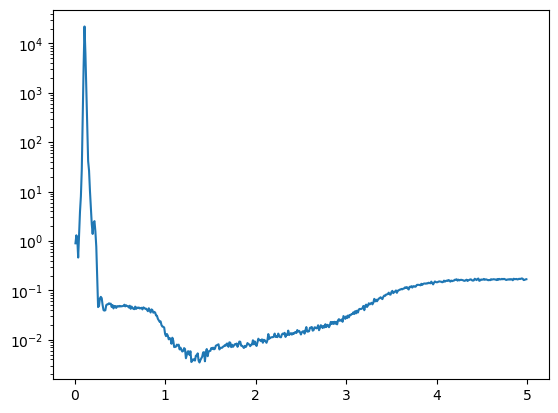

In [12]:

def relative_error(f,y):
    return ((f-y).T@(f-y))/(y.T@y)


errs = []
errs_t = []
cv = ShuffleSplit(n_splits=10, random_state=0)

l_range = np.arange(0.01,5, 0.01)
for l in l_range:
    err = 0
    err_t = 0
    eta = 5e-8
    T = t_sample.reshape(-1,1)
    for train, test in cv.split(T):
        scaler = StandardScaler()
        y_train = u_sample[train]
        x_train = T[train]
        x_train_scaled = scaler.fit_transform(x_train)
        y_test = u_t_sample[test]
        x_test = T[test]
        x_test_scaled = scaler.transform(x_test)
        u_t_star = smoothDif(x_train, x_test, y_train, 0, eta,l)
        err_t += relative_error(u_t_star, y_test)
        # err_t += mean_squared_error(u)
    # errs.append(err/10)
    errs_t.append(err_t/10)
    print(l, err_t/10)

lowest_index = errs_t.index(min(errs_t))
print('lowest l', l_range[lowest_index])
print(min(errs_t))

# plt.plot(g_range, errs)
plt.semilogy(l_range, errs_t)

0.01 0.00033416147712996816
0.015 0.00025587938203881446
0.019999999999999997 0.00012924957811928
0.024999999999999998 5.0696272249303665e-05
0.03 1.990308956144756e-05
0.034999999999999996 1.299453437906604e-05
0.039999999999999994 1.3568525372066068e-05
0.045 1.6559112094556007e-05
0.049999999999999996 2.152813822287464e-05
0.05499999999999999 2.9007153369471378e-05
0.05999999999999999 4.102955738216113e-05
0.06499999999999999 6.683863990048632e-05
0.06999999999999999 0.000145847562587246
0.07499999999999998 0.0004353755242959556
0.07999999999999999 0.0015251036168816435
0.08499999999999999 0.0054598692418030455
0.08999999999999998 0.018708087396248373
0.09499999999999999 0.05963048207569417
0.09999999999999999 0.17026883565637727
0.10499999999999998 0.3642194487288049
0.10999999999999999 0.39390529219427806
0.11499999999999999 0.16013533707588873
0.11999999999999998 0.04804094016696358
0.12499999999999999 0.02226068606855114
0.12999999999999998 0.01327574930423569
0.1349999999999999

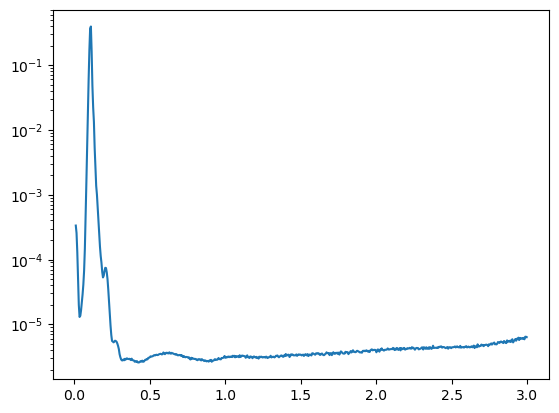

In [13]:
errs = []
cv = ShuffleSplit(n_splits=10, random_state=0)

l_range = np.arange(0.01, 3, 0.005)
for l in l_range:
    err = 0
    err_t = 0
    eta = 1e-7
    T = t_sample.reshape(-1,1)
    for train, test in cv.split(T):
        scaler = StandardScaler()
        y_train = u_sample[train]
        x_train = T[train]
        x_train_scaled = scaler.fit_transform(x_train)
        y_test = u_sample[test]
        x_test = T[test]
        x_test_scaled = scaler.transform(x_test)
        P_star = smooth(x_train, x_test, y_train, eta,l)
        err += mean_squared_error(P_star, y_test)
    errs.append(err/10)
    print(l, err/10)

lowest_index = errs.index(min(errs))
print('lowest l', l_range[lowest_index])
print(min(errs))

# plt.plot(g_range, errs)
plt.semilogy(l_range, errs)

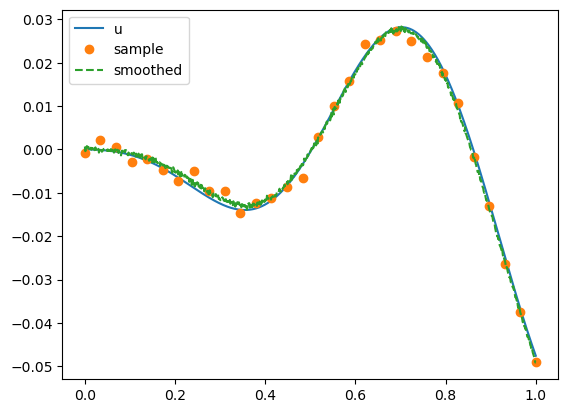

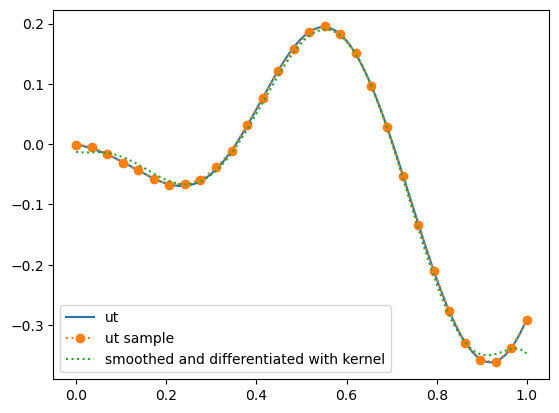

In [14]:
T_train = t_sample.reshape(-1,1)
T_train_scaled = scaler.fit_transform(T_train)

T_test = t.reshape(-1,1)
T_test_scaled = scaler.transform(T_test)

T = t.reshape(-1,1)

l = 1.335
lam = 5e-8
smoothed = smooth(T_train, T_test, u_sample, lam, l)
plt.plot(t,u, label='u')
plt.plot(t_sample, u_sample, 'o', label='sample')
plt.plot(t,smoothed, '--', label='smoothed')
plt.legend()

plt.figure()
smoothed_t = smoothDif(T_train, T_test, u_sample, 0, lam, l)
plt.plot(t,ut,label='ut')
plt.plot(t_sample,u_t_sample,'o:',label='ut sample')
plt.plot(t,smoothed_t,':',label='smoothed and differentiated with kernel')



plt.legend()

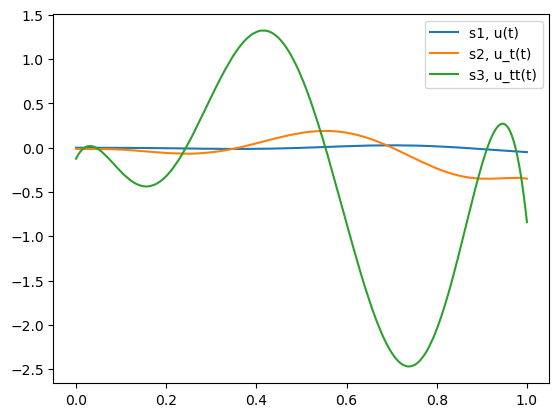

In [15]:
l = 1.335
lam = 5e-8

s1_sample = smooth(T_train, T_test, u_sample, lam, l)
s2_sample = smoothDif(T_train, T_test, u_sample, 0, lam, l)
s3_sample = smooth2ndDif(T_train, T_test, u_sample, 0, lam, l)

plt.plot(t, s1_sample, label='s1, u(t)')
plt.plot(t, s2_sample, label='s2, u_t(t)')
plt.plot(t, s3_sample, label='s3, u_tt(t)')
plt.legend()

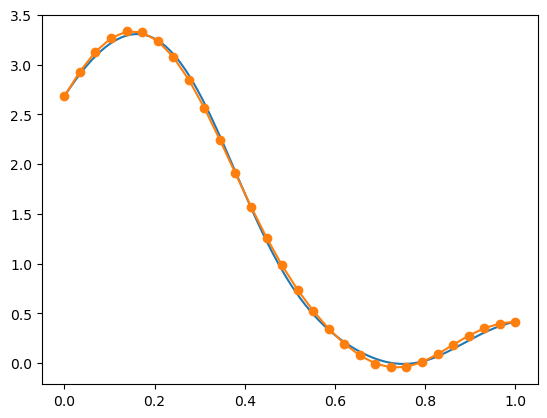

In [54]:
s1_sample = smooth(T_train, T_train, u_sample, lam, l)
s2_sample = smoothDif(T_train, T_train, u_sample, 0, lam, l)
s3_sample = smooth2ndDif(T_train, T_train, u_sample, 0, lam, l)

S_sample = np.column_stack((T_train, s1_sample,s2_sample,s3_sample))
S_sample_scaled = scaler.fit_transform(S_sample)
beta = 0.05
f_perturbed = fi +  beta * np.sin(5 * np.pi * t)
f_sample = f_perturbed[::31]

# K = RBF()
# eta2 = 1e-5
# K_inv_f = np.linalg.solve(K(S_scaled,S_scaled) + eta2*np.eye(len(S_scaled)), f_sample)
# P = K(S_scaled,S_scaled) @ K_inv_f

plt.plot(t, fi,'-')
plt.plot(t_sample, f_sample,'o-')


0.01 3.4037120310595554
0.02 3.108576919929516
0.03 2.4303296592153463
0.04 1.875491256657627
0.05 1.4004877102102598
0.06 1.0061048525368226
0.07 0.7019377241393292
0.08 0.4807332977365436
0.09 0.32734861860708336
0.1 0.2238718833817325
0.11 0.15425599413022903
0.12 0.10687900050463928
0.13 0.07462737667237761
0.14 0.05325452926425504
0.15 0.03969214630938242
0.16 0.03136419316825624
0.17 0.026213781916261347
0.18 0.022812773720303364
0.19 0.02030411322009503
0.2 0.018236140353480597
0.21 0.016397061025577548
0.22 0.014698404225646323
0.23 0.013108223243259975
0.24 0.011618052426014047
0.25 0.010228191084707731
0.26 0.008941515508689265
0.27 0.007760861310563388
0.28 0.0066878655513636686
0.29 0.005722462646428601
0.3 0.004862711166126923
0.31 0.00410481439964115
0.32 0.0034432844370636947
0.33 0.0028712289140548726
0.34 0.002380733086459792
0.35000000000000003 0.001963293562896834
0.36 0.0016102545597271808
0.37 0.0013132088815318995
0.38 0.0010643454827798595
0.39 0.0008567364816396

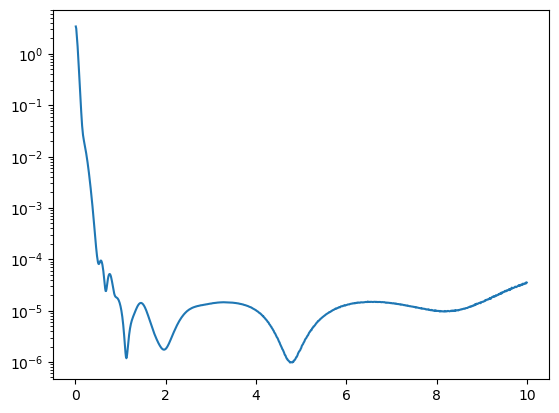

In [49]:
errs = []
cv = ShuffleSplit(n_splits=10, random_state=0)

l_range = np.arange(0.01, 10, 0.01)
for l in l_range:
    err = 0
    err_t = 0
    eta = 1e-7
    T = t_sample.reshape(-1,1)
    for train, test in cv.split(S_sample):
        scaler = StandardScaler()
        y_train = f_sample[train]
        x_train = S_sample[train]
        x_train_scaled = scaler.fit_transform(x_train)
        y_test = f_sample[test]
        x_test = S_sample[test]
        x_test_scaled = scaler.transform(x_test)
        P_star = smooth(x_train, x_test, y_train, eta,l)
        err += mean_squared_error(P_star, y_test)
    errs.append(err/10)
    print(l, err/10)

lowest_index = errs.index(min(errs))
print('lowest l', l_range[lowest_index])
print(min(errs))

# plt.plot(g_range, errs)
plt.semilogy(l_range, errs)

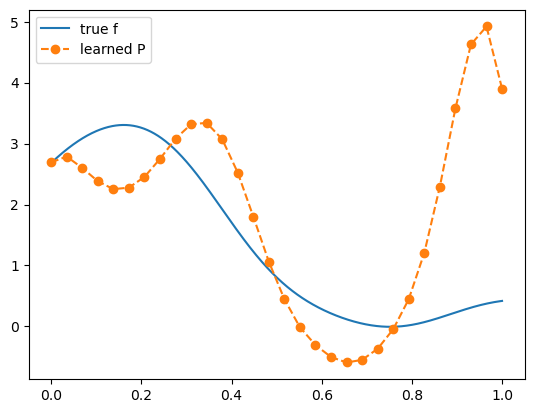

In [55]:
K = RBF(4.75)
eta2 = 1e-7
S_sample = np.column_stack((T_train, s1_sample,s2_sample,s3_sample))
scaler = StandardScaler()
S_sample_scaled = scaler.fit_transform(S_sample)

l = 1.335
lam = 5e-8
s1 = smooth(T_train, T, u_sample, lam, l)
s2 = smoothDif(T_train, T, u_sample, 0, lam, l)
s3 = smooth2ndDif(T_train, T, u_sample, 0, lam, l)
S = np.column_stack((T,s1,s2,s3))
S_scaled = scaler.transform(S)

K_inv_f = np.linalg.solve(K(S_sample_scaled,S_sample_scaled) + eta2*np.eye(len(S_sample_scaled)), f_sample)
P = K(S_scaled,S_sample_scaled) @ K_inv_f

plt.plot(t,fi,'-',label='true f')
plt.plot(t_sample,P,'o--', label='learned P')
plt.legend()